In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.SOLPSreader import read_balance

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = read_balance(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(params["Bpol"], params["Btot"], params["R"], params["Z"], params["Spar"], params["Spol"], params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [7]:
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

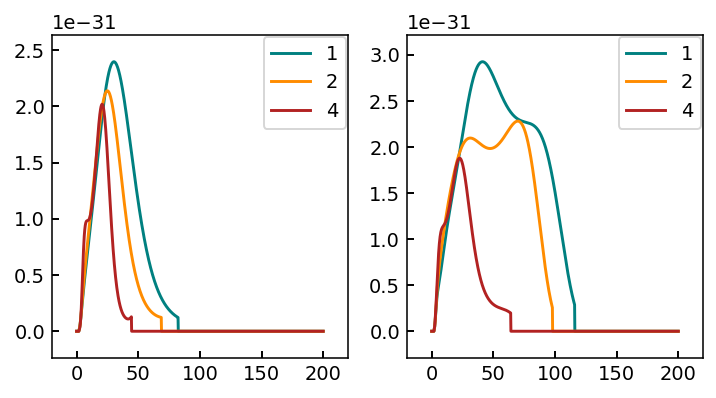

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [9]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

(-10.0, 200.0)

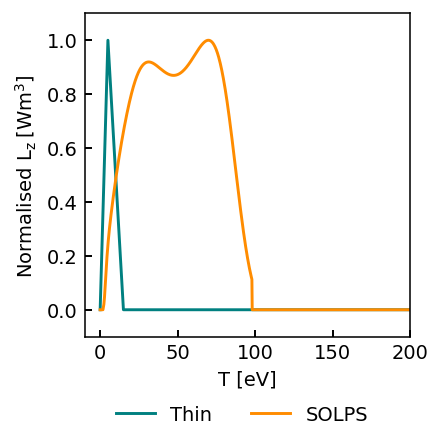

In [10]:
curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

### Inner

(-10.0, 200.0)

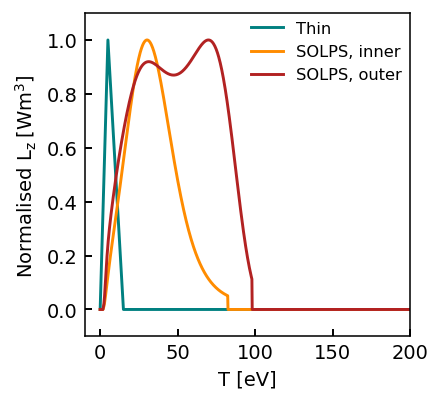

In [11]:
curves["set_inner"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Curve 2" : curves["neTau"][1e20],
    # "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))

curves_plot = {
    "Thin" : curves["set_inner"]["Thin"],
    "SOLPS, inner" : curves["set_inner"]["SOLPS"],
    "SOLPS, outer" : curves["set_outer"]["SOLPS"],
}

for name, function in curves_plot.items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
ax.legend(fontsize = "small", loc = "upper right", bbox_to_anchor = (1,1), ncol = 1, frameon = False)
ax.set_xlim(-10,200)
# fig.savefig(r"C:\Users\Mike\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\RadiationImpact_curves.pdf", format = "pdf")

# Profile grid

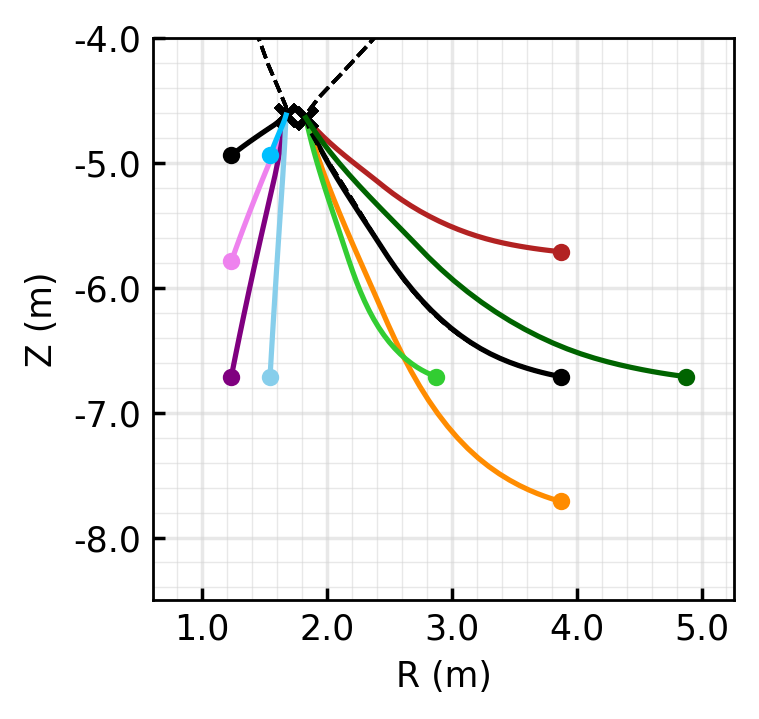

In [15]:
base_profile = dict(inner = eqb_alt['100MW_innerar_midplanepuff']["inner_lower"][sepadd_select["inner_lower"]], 
                    outer = eqb_alt['100MW_innerar_midplanepuff']["outer_lower"][sepadd_select["outer_lower"]])

base_profile_interp = {}

upper_lim = -4.8
lower_lim = -8
right_lim = 5
left_lim = 0.8
res = 10


coords = {
    "outer" : {
        "Baseline" : (base_profile["outer"]["R"][0], base_profile["outer"]["Z"][0]), 
        "Down 1m" : (base_profile["outer"]["R"][0], base_profile["outer"]["Z"][0]-1), 
        "Up 1m" : (base_profile["outer"]["R"][0], base_profile["outer"]["Z"][0]+1), 
        "In 1m" : (base_profile["outer"]["R"][0]-1, base_profile["outer"]["Z"][0]), 
        "Out 1m" : (base_profile["outer"]["R"][0]+1, base_profile["outer"]["Z"][0]),
        # "Out 1m, down 1m" : (base_profile["outer"]["R"][0]+1, base_profile["outer"]["Z"][0]-1), 
        # "Out 1m, up 1m" : (base_profile["outer"]["R"][0]+1, base_profile["outer"]["Z"][0]+1), 
    },
    
    "inner" : {
        "Baseline" : (base_profile["inner"]["R"][0], base_profile["inner"]["Z"][0]), 
        "Halfway down" : (base_profile["inner"]["R"][0], base_profile["inner"]["Z"][0]-0.85), 
        "In-line with outer" : (base_profile["inner"]["R"][0], base_profile["outer"]["Z"][0]),
        "In-line with outer, out" : (base_profile["inner"]["R"][0]+0.31, base_profile["outer"]["Z"][0]),
        "Out" : (base_profile["inner"]["R"][0]+0.31, base_profile["inner"]["Z"][0]), 
        # "Halfway down, right" : (base_profile["inner"]["R"][0]+0.2, base_profile["inner"]["Z"][0]-0.85),  
    },
}



profiles_constBpol = {}

for side in ["inner", "outer"]:
    profiles_constBpol[side] = {}
    for i, name in enumerate(coords[side].keys()):
    
        x = coords[side][name][0]
        y = coords[side][name][1]
        p2 = base_profile[side].copy()
        offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], x, y)
        
        profiles_constBpol[side][name] = p2.offset_control_points(offsets, constant_pitch = False).geometry

            
        # ax.plot(base_profile[side]["R"], base_profile[side]["Z"], ls = "--", c = "darkslategrey")

        profiles_constBpol[side][name].plot(ax = ax, mode = "RZ", color = "deeppink", ls = "-", lw = 3, alpha = 0.1)
        profile = profiles_constBpol[side][name]
        # ax.plot(profile["R"][0], profile["Z"][0], marker = "o", color = "red", ms = 3, alpha = 0.5)
                
        base_x = base_profile[side]["R"][0]
        base_y = base_profile[side]["Z"][0]
        
        p2 = base_profile[side].copy()
        offsets = p2.get_offsets_strike_point([1, 0.9, 0.6, 0.59, 0.2, 0.1, 0.05, 0], base_x, base_y)
        base_profile_interp[side] = p2.offset_control_points(offsets, constant_pitch = False).geometry


colors = dict( 
              
              outer = {
                "Baseline" : "black", 
                "Down 1m" : "darkorange", 
                "Up 1m" : "firebrick", 
                "In 1m" : "limegreen", 
                "Out 1m" : "darkgreen", 
                'Out 1m, down 1m' : "skyblue",
                'Out 1m, up 1m' : "purple" 
                },
              
              inner = {
            "Baseline" : "black", 
            "Halfway down" : "violet", 
            "In-line with outer" : "purple", 
            "In-line with outer, out" : "skyblue",
            "Out" : "deepskyblue",
            "Halfway down, right" : "skyblue",
        }
)

fig, ax = plt.subplots(dpi = 250, figsize = (3,3))

def plot_profiles(ax, xlim = (None, None), ylim = (-8.5, -4.0)):
    for side in ["inner", "outer"]:
        for i, name in enumerate(coords[side].keys()):
            
            ax.plot(base_profile[side]["R"], base_profile[side]["Z"], ls = "--", c = "k", lw = 1)
            
            Xpoint = base_profile[side]["Xpoint"]
            ax.plot(base_profile[side]["R"][Xpoint], base_profile[side]["Z"][Xpoint], marker = "x", markeredgewidth = 2, zorder = 2,  c = "black")
            
            profiles_constBpol[side][name].plot(ax = ax, mode = "RZ", color = colors[side][name], ls = "-", lw = 1.5, alpha = 1)
            profile = profiles_constBpol[side][name]
            ax.plot(profile["R"][0], profile["Z"][0], marker = "o", color = colors[side][name], ms = 4, alpha = 1)
            
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_aspect("equal")
    
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.grid(True, which = "major", lw = 1)
    ax.grid(True, which = "minor", lw = 0.4)
    
plot_profiles(ax)
# ax.set_title("Profile shapes")
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\Sensitivity_profiles.pdf", format = "pdf")

# Run DLS

In [16]:
def run_DLS(constants_input, profile, SparRange, slc, cvar, region, sepadd, hflux_corr=1):
    if "cooling_curve" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")

    df = slc.get_1d_poloidal_data(
        ["Ne"], sepadd=sepadd, region=region, target_first=True
    )
    nu = df["Ne"].iloc[-1]
    
    # This comes from the SOLPS comparison match for the specific SOL rings
    if "inner" in region:
        qpllu0 = 2.5e8 * 0.98
        kappa = 1.9 * 2500
    else:
        qpllu0 = 3.0e8 * 1.14
        kappa = 1.28 * 2500

    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=SparRange,
        qpllu0=qpllu0,
        nu0=nu,
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve(
            "Ar", region, sepadd=sepadd, plot=False
        ),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        Ctol = 1e-5,
        Ttol = 1e-4,
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )
    
    try:
        out = run_dls(
            dataclasses.replace(inputs, **constants_input),
            profile,
            verbosity = 1
        )

    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(
        slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
    )

## Run baseline

In [17]:
store = {}
comps = {}
base = {}

for side in ["outer", "inner"]:
    store[side] = {}
    for curve in ["Thin", "SOLPS"]:
        store[side][curve] = {}

## Study function

In [18]:
def run_study(side, region, curve, profiles):
    store_out = {}
    for i, name in enumerate(coords[side].keys()):
        
        x = coords[side][name][0]
        y = coords[side][name][1]

        print(f"Solving profile {x:.2f}, {y:.2f} ------")
        input = dict(cooling_curve=curves[f"set_{side}"][curve])
        profile = profiles[side][name]       
        
        SparRange = profile.spar_range(mode = "equally_spaced_parallel", npoints = 30)
        out, comp = run_DLS(
            input,
            profile,
            SparRange,
            store_slc[case],
            "density",
            region,
            sepadd_select[region],
            hflux_corr=1,
        )
        store_out[name] = out
        
            
    return store_out

## Run strike points 

In [19]:
# for side in ["outer"]:
for side in ["outer", "inner"]:
    print(    f"\n-------------------------------------Running {side}-------------------------------------")
    for curve in [
        "Thin", 
        "SOLPS"
        ]:
        print(f"\n-------------------------------------{curve}-------------------------------------")
        store[side][curve] = run_study(side, f"{side}_lower", curve, profiles_constBpol)



-------------------------------------Running outer-------------------------------------

-------------------------------------Thin-------------------------------------
Solving profile 3.87, -6.71 ------
Solving...0.00...0.59...1.18...
1.78...2.37...2.96...3.55...4.15...4.74...5.33...5.92...6.52...
7.11...7.70...8.29...8.88...9.48...10.07...10.66...11.25...11.85...
12.44...13.03...13.62...14.21...14.81...

15.40...15.99...16.58...17.18...Complete in 35.7 seconds
Solving profile 3.87, -7.71 ------
Solving...0.00...0.76...1.52...2.28...
3.04...3.80...4.56...5.32...6.08...6.84...7.59...8.35...9.11...9.87...10.63...

11.39...12.15...12.91...13.67...14.43...
15.19...15.95...16.71...17.47...
18.23...18.99...19.75...20.51...21.27...22.02...Complete in 35.0 seconds
Solving profile 3.87, -5.71 ------
Solving...0.00...0.45...0.91...1.36...1.81...2.27...2.72...3.17...3.62...4.08...4.53...4.98...5.44...5.89...6.34...6.80...

7.25...7.70...8.15...8.61...9.06...9.51...9.97...10.42...10.87...11.33...

## Save/Load

In [ ]:
save_package = dict(base = base, store = store)
write_file(save_package, "strikepoint_opt_actualsensitivity_v1b.dill")

strikepoint_opt_actualsensitivity_v1.dill written


### Load

In [ ]:
save_package = read_file("strikepoint_opt_actualsensitivity_v1b.dill")
base = save_package["base"]
store = save_package["store"]

strikepoint_opt_actualsensitivity_v1.dill loaded


# Analysis

In [18]:
store[side]["SOLPS"].keys()

dict_keys(['Baseline', 'Down 1m', 'Up 1m', 'In 1m', 'Out 1m'])

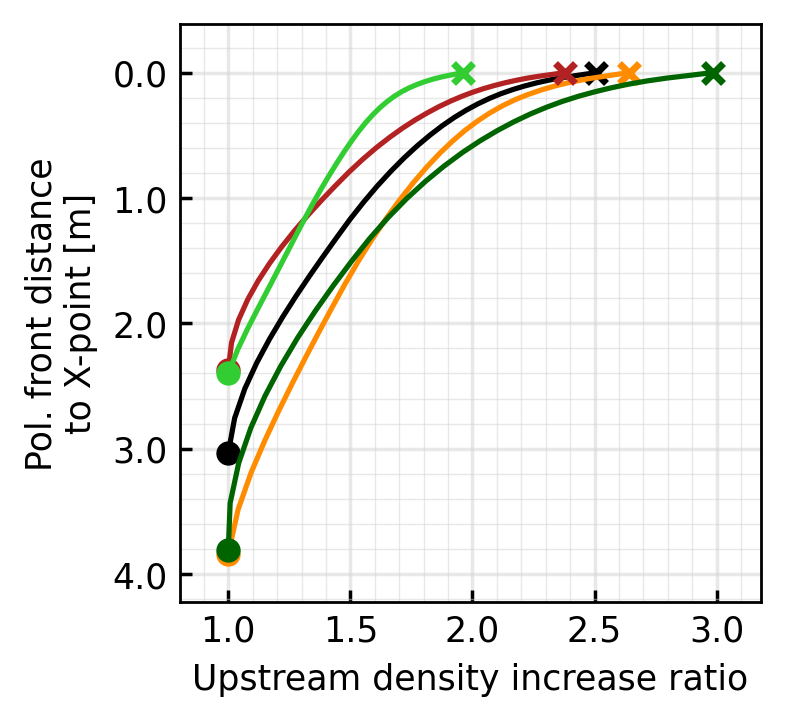

In [20]:


def plot_outer(ax, curve):
    side = "outer"

    colors = {
            "Baseline" : "black", 
            "Down 1m" : "darkorange", 
            "Up 1m" : "firebrick", 
            "In 1m" : "limegreen", 
            "Out 1m" : "darkgreen", 
            'Out 1m, down 1m' : "skyblue",
            'Out 1m, up 1m' : "purple" 
        }

    styles = dict(
        Thin = {"ls" : ":"},
        SOLPS = {"ls" : "-"}
    )

    for i, name in enumerate(coords[side].keys()):
        
        if not any([x in name for x in ["Out 1m, down 1m", "Out 1m, up 1m"]]):


            out = store[side][curve][name]
            base = store[side][curve]["Baseline"]
            crel = np.array(out["cvar"]) / np.array(out["cvar"][0])
            cvar = out["cvar"]
        
            Spol = out["Spol_front"]
            yplot = abs(Spol - Spol[-1])
            xplot = crel
            
            if curve == "SOLPS":
                label= name
            else:
                label = ""    

            ax.plot(xplot, yplot, c = colors[name], label = label)
            ax.plot(xplot[0], yplot[0], marker = "o", c = colors[name])
            ax.plot(xplot[-1], yplot[-1], marker = "x", markeredgewidth = 2, c = colors[name])
            
    ax.invert_yaxis()    
    ax.set_xlabel("Upstream density increase ratio")
    ax.set_ylabel("Pol. front distance\nto X-point [m]", fontsize = "medium")

    # ax.legend(fontsize = "small", edgecolor = "None")
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.grid(True, which = "major", lw = 1)
    ax.grid(True, which = "minor", lw = 0.4)

fig, ax = plt.subplots(dpi = 250, figsize = (3,3))
plot_outer(ax, "Thin")
    # fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\Sensitivity_outer.pdf", format = "pdf")

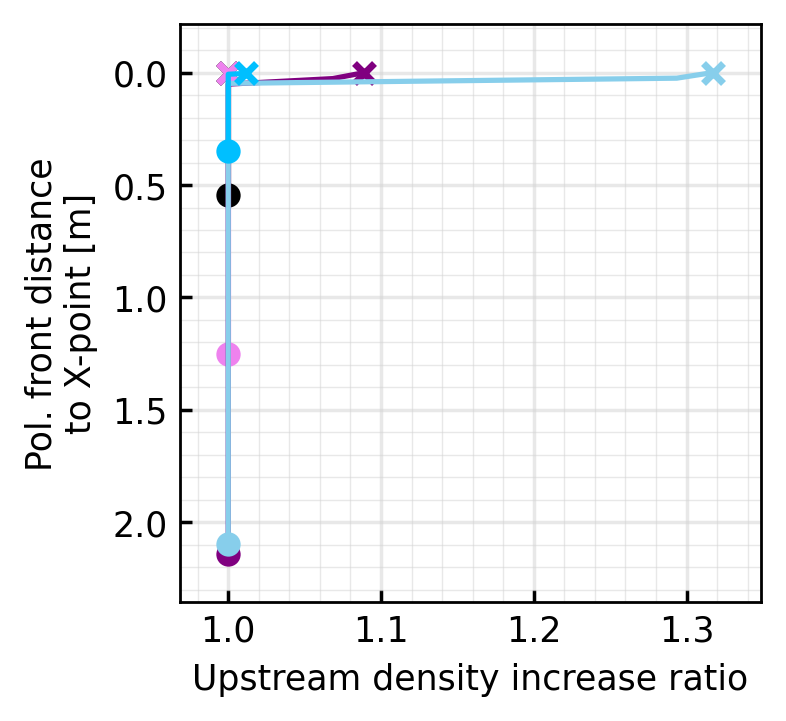

In [22]:

def plot_inner(ax, curve):
    side = "inner"

    colors = {
            "Baseline" : "black", 
            "Halfway down" : "violet", 
            "In-line with outer" : "purple", 
            "Out" : "deepskyblue",
            "Halfway down, right" : "skyblue",
            "In-line with outer, out" : "skyblue",
        }

    styles = dict(
        Thin = {"ls" : ":"},
        SOLPS = {"ls" : "-"}
    )

    for i, name in enumerate(coords[side].keys()):
        
        if not any([x in name for x in [
            # "In-line with outer",
            # "Out"
            ]]):


            out = store[side][curve][name]
            base = store[side][curve]["Baseline"]
            crel = np.array(out["cvar"]) / np.array(out["cvar"][0])
            cvar = out["cvar"]
        
            Spol = out["Spol_front"]
            yplot = abs(Spol - Spol[-1])
            xplot = crel
            
            if curve == "SOLPS":
                label= name
            else:
                label = ""   
                
            if xplot[-1] < xplot[0]:
                xplot = [xplot[0], xplot[0]]
                yplot = [yplot[0], 0]
                
            if any([x < 1 for x in xplot]):
                for i, x in enumerate(xplot):
                    if x > 1:
                        ibreak = i-2
                        
                xplot = np.concatenate([[xplot[0]], xplot[ibreak:]])
                yplot = np.concatenate([[yplot[0]], yplot[ibreak:]])

                
                xplot[1] = 1
                yplot[1] = yplot[1] + (yplot[2] - yplot[1]) * (1 - xplot[1]) / (xplot[2] - xplot[1])


            ax.plot(xplot, yplot, c = colors[name], label = label)
            ax.plot(xplot[0], yplot[0], marker = "o", c = colors[name])
            ax.plot(xplot[-1], yplot[-1], marker = "x", markeredgewidth = 2, c = colors[name])
            
    ax.invert_yaxis()    
    ax.set_xlabel("Upstream density increase ratio")
    ax.set_ylabel("Pol. front distance\nto X-point [m]", fontsize = "medium")
    # ax.legend(fontsize = "small", edgecolor = "None")

    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.grid(True, which = "major", lw = 1)
    ax.grid(True, which = "minor", lw = 0.4)
    # fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\Sensitivity_inner.pdf", format = "pdf")
    
fig, ax = plt.subplots(dpi = 250, figsize = (3,3))
plot_inner(ax, "Thin")

# Combined figure

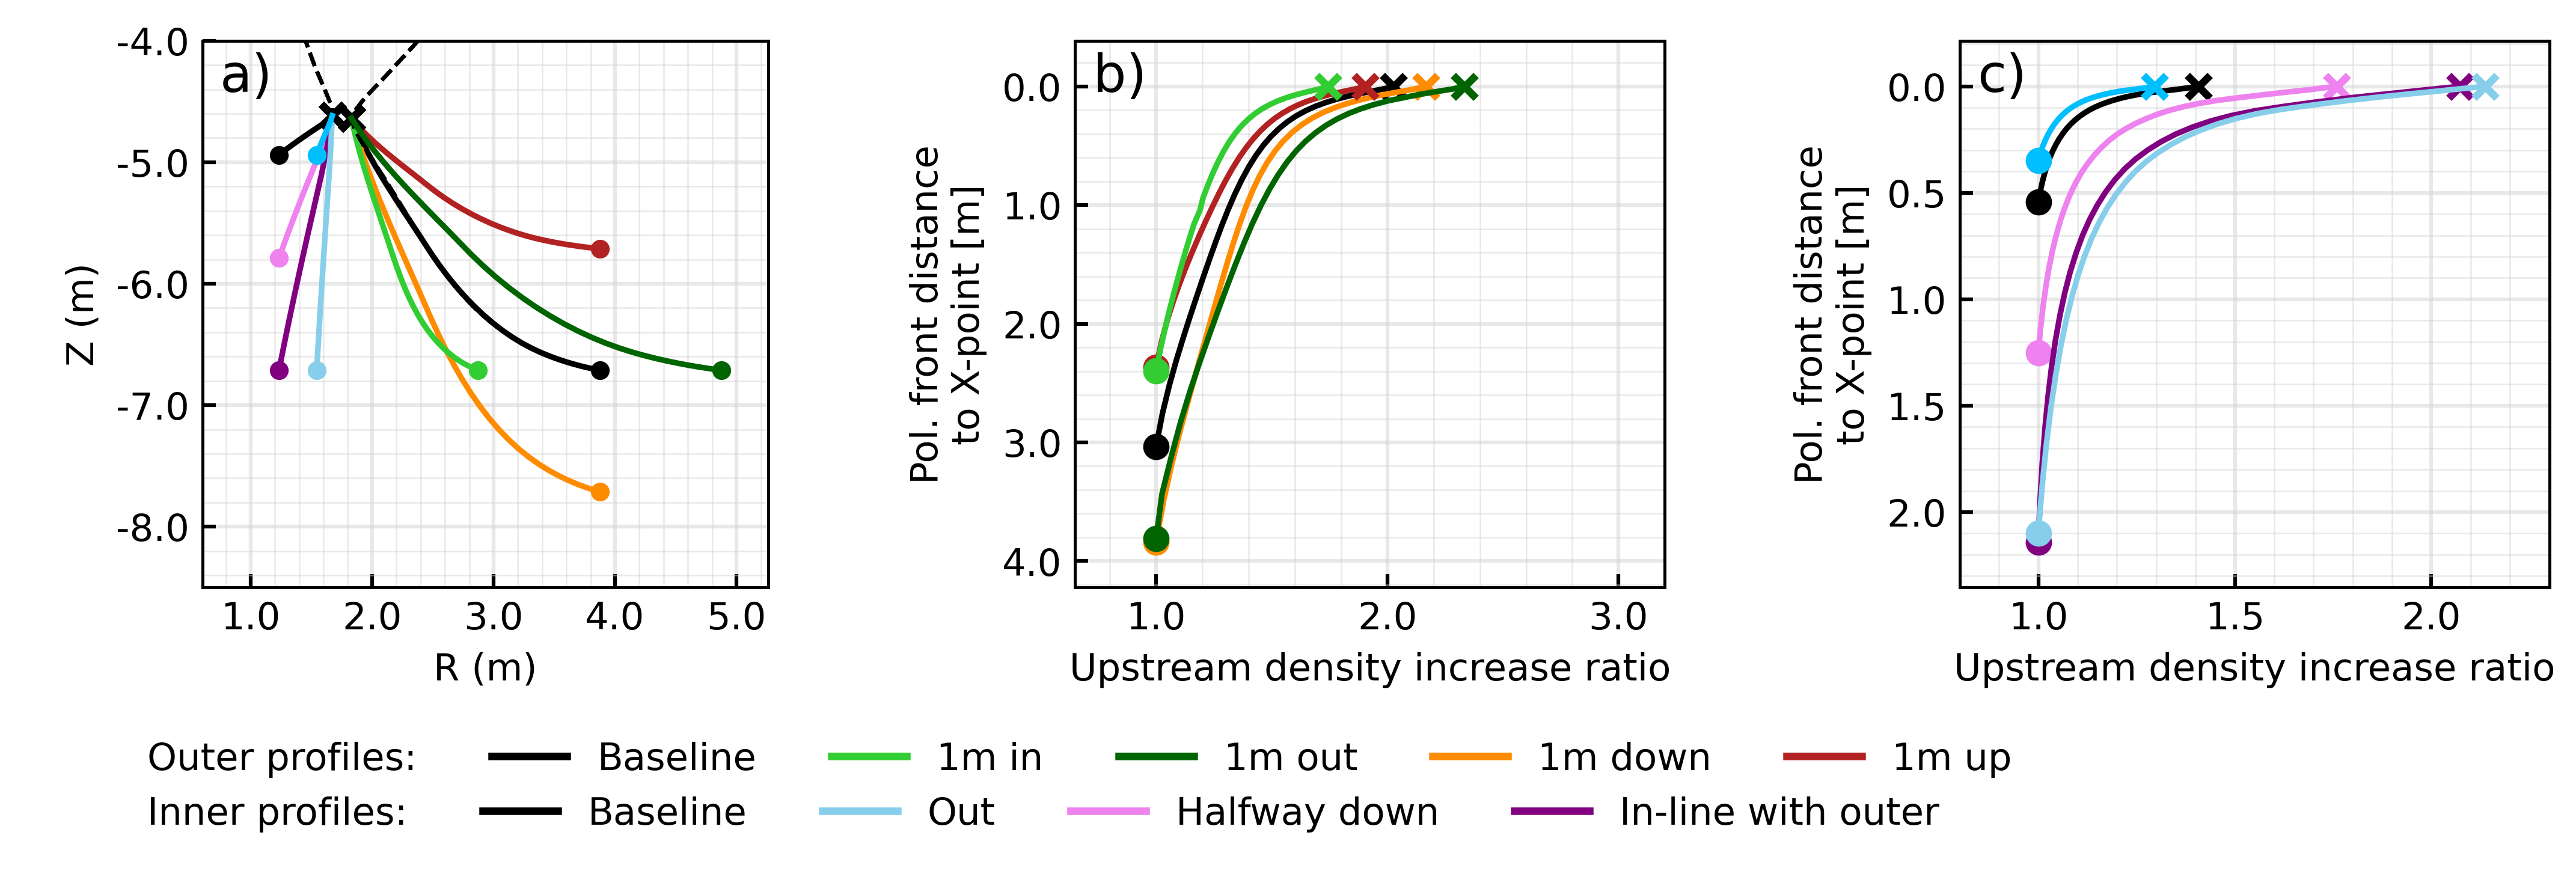

In [23]:
thin = False
scale = 0.75
fig, axes = plt.subplots(1,3, dpi = 450, figsize = (15*scale,3.5*scale))
fontsize = 14
ax = axes[0]
plot_profiles(ax)
ax.text(0.03, 0.98, "a)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")

ax = axes[1]
plot_outer(axes[1], "SOLPS")
ax.text(0.03, 0.98, "b)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")
ax.set_xlim(0.65, 3.2)

ax = axes[2]
plot_inner(axes[2], "SOLPS")
ax.text(0.03, 0.98, "c)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")
ax.set_xlim(0.8, 2.3)

fig.subplots_adjust(wspace = 0.5)
lw = 2

outer_profiles = [
    mpl.lines.Line2D([], [], color = "None", label = "Outer profiles:"),
    mpl.lines.Line2D([0], [0], color = "black", lw = lw, label = "Baseline"),
    mpl.lines.Line2D([0], [0], color = "limegreen", lw = lw, label = "1m in"),
    mpl.lines.Line2D([0], [0], color = "darkgreen", lw = lw, label = "1m out"),
    mpl.lines.Line2D([0], [0], color = "darkorange", lw = lw, label = "1m down"),
    mpl.lines.Line2D([0], [0], color = "firebrick", lw = lw, label = "1m up"),
]

inner_profiles = [
    mpl.lines.Line2D([], [], color = "None", label = "Inner profiles:"),
    mpl.lines.Line2D([0], [0], color = "black", lw = lw, label = "Baseline"),
    mpl.lines.Line2D([0], [0], color = "skyblue", lw = lw, label = "Out"),
    mpl.lines.Line2D([0], [0], color = "violet", lw = lw, label = "Halfway down"),
    mpl.lines.Line2D([0], [0], color = "purple", lw = lw, label = "In-line with outer"),
]



hoffset = 0.07
voffset = -0.08
fig.legend(ncols = 6, edgecolor = "None", handles = outer_profiles, loc = "upper left", bbox_to_anchor = (hoffset, 0 + voffset))
fig.legend(ncols = 6, edgecolor = "None", handles = inner_profiles, loc = "upper left", bbox_to_anchor = (hoffset, -0.077 + voffset))
# fig.legend(ncols = 1, edgecolor = "None", handles = curves, loc = "upper center", bbox_to_anchor = (0.8, 0.03 + voffset))

# fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\Sensitivity_allplots_solps.pdf", format = "pdf")

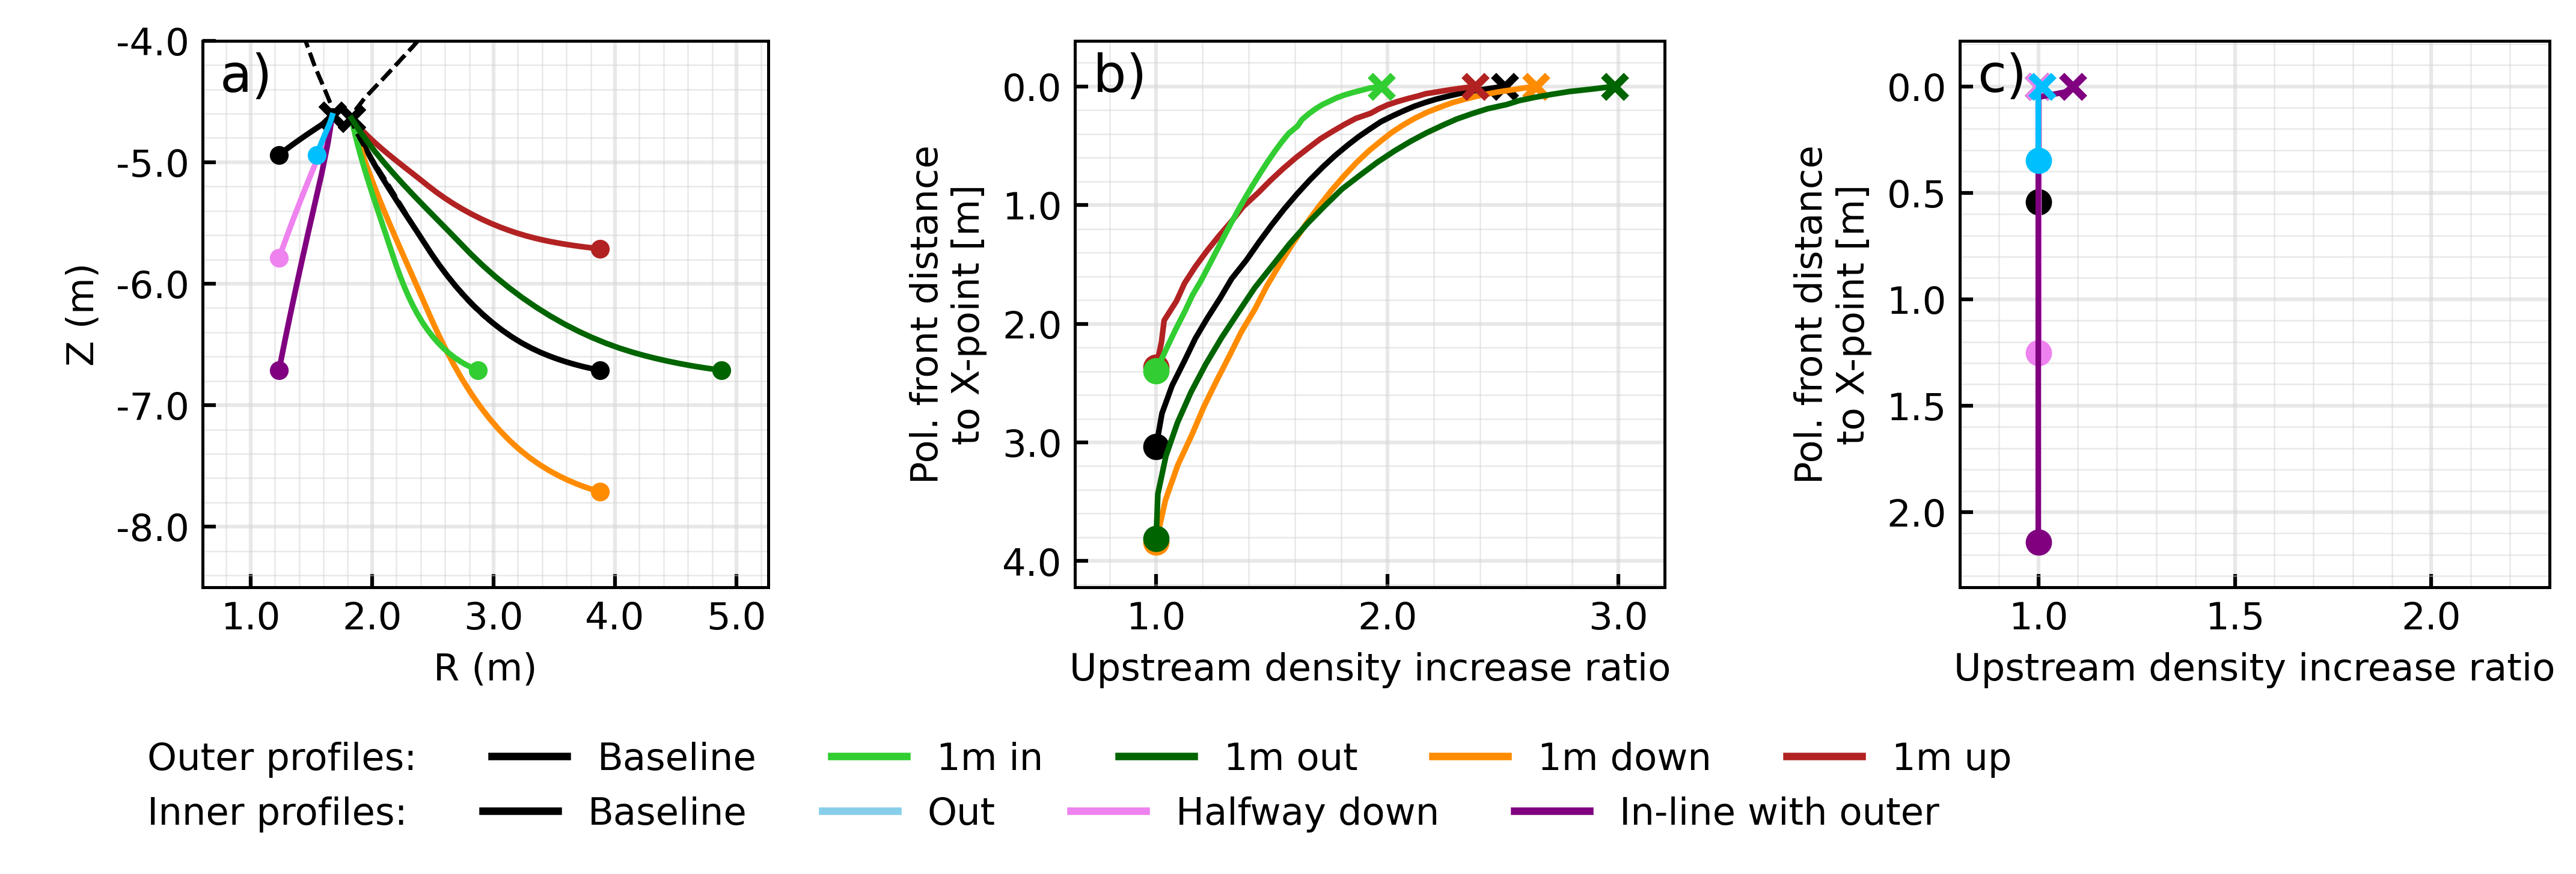

In [22]:
thin = False
scale = 0.75
fig, axes = plt.subplots(1,3, dpi = 450, figsize = (15*scale,3.5*scale))
fontsize = 14
ax = axes[0]
plot_profiles(ax)
ax.text(0.03, 0.98, "a)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")

ax = axes[1]
plot_outer(axes[1], "Thin")
ax.text(0.03, 0.98, "b)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")
ax.set_xlim(0.65, 3.2)

ax = axes[2]
plot_inner(axes[2], "Thin")
ax.text(0.03, 0.98, "c)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")
ax.set_xlim(0.8, 2.3)

fig.subplots_adjust(wspace = 0.5)
lw = 2

outer_profiles = [
    mpl.lines.Line2D([], [], color = "None", label = "Outer profiles:"),
    mpl.lines.Line2D([0], [0], color = "black", lw = lw, label = "Baseline"),
    mpl.lines.Line2D([0], [0], color = "limegreen", lw = lw, label = "1m in"),
    mpl.lines.Line2D([0], [0], color = "darkgreen", lw = lw, label = "1m out"),
    mpl.lines.Line2D([0], [0], color = "darkorange", lw = lw, label = "1m down"),
    mpl.lines.Line2D([0], [0], color = "firebrick", lw = lw, label = "1m up"),
]

inner_profiles = [
    mpl.lines.Line2D([], [], color = "None", label = "Inner profiles:"),
    mpl.lines.Line2D([0], [0], color = "black", lw = lw, label = "Baseline"),
    mpl.lines.Line2D([0], [0], color = "skyblue", lw = lw, label = "Out"),
    mpl.lines.Line2D([0], [0], color = "violet", lw = lw, label = "Halfway down"),
    mpl.lines.Line2D([0], [0], color = "purple", lw = lw, label = "In-line with outer"),
]

curve_handles = [
    mpl.lines.Line2D([], [], color = "None", label = "Cooling curves:"),
    mpl.lines.Line2D([0], [0], color = "darkslategray", lw = lw, label = "Argon (SOLPS)"),
    mpl.lines.Line2D([0], [0], color = "darkslategray", lw = lw, ls = ":", label = "Thin"),
]

hoffset = 0.07
voffset = -0.08
fig.legend(ncols = 6, edgecolor = "None", handles = outer_profiles, loc = "upper left", bbox_to_anchor = (hoffset, 0 + voffset))
fig.legend(ncols = 6, edgecolor = "None", handles = inner_profiles, loc = "upper left", bbox_to_anchor = (hoffset, -0.077 + voffset))
# fig.legend(ncols = 1, edgecolor = "None", handles = curves, loc = "upper center", bbox_to_anchor = (0.8, 0.03 + voffset))

fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\Sensitivity_allplots_thin.pdf", format = "pdf")

# All combined

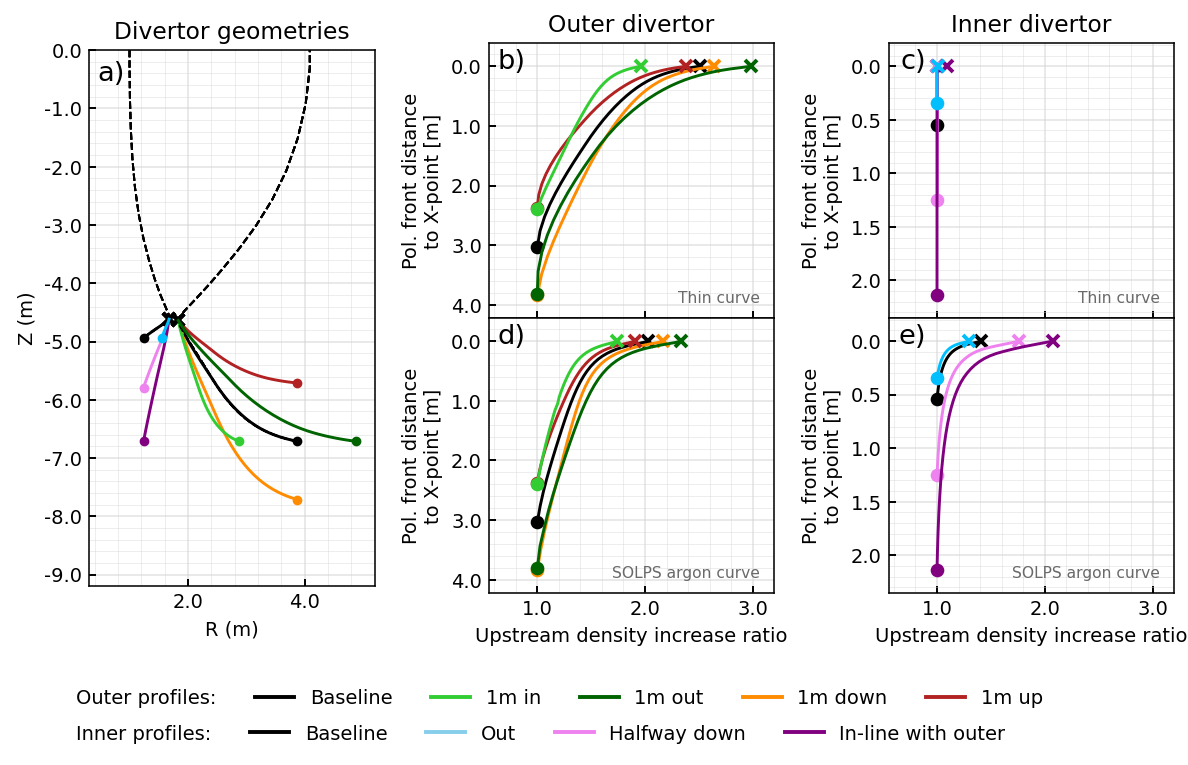

In [61]:
fontsize = 14
fig = plt.figure(figsize=(10, 5.1))
gs = mpl.gridspec.GridSpec(2, 3, figure=fig, hspace = 0.0, wspace = 0.4)

# First column: double-height plot
ax1 = fig.add_subplot(gs[:, 0])   # span both rows

# Second column: top and bottom
ax2 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1], sharex = ax2)

# Third column: top and bottom
ax3 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2], sharex = ax3)

ax = ax1
plot_profiles(ax, ylim = (-9.2, 0), xlim = (0.3, 5.2))
ax.text(0.03, 0.98, "a)", transform=ax.transAxes, fontsize = fontsize, ha="left", va="top")
ax.set_title("Divertor geometries")

xlim = (0.55, 3.2)
labelx = 0.95
labely = 0.1
labelfs = 8
labelha = "right"
labelc = "dimgrey"
letterx = 0.13

ax = ax2
plot_outer(ax, "Thin")
ax.text(letterx, 0.98, "b)", transform=ax.transAxes, fontsize = fontsize, ha=labelha, va="top")
ax.set_xlim(xlim)
ax.set_title("Outer divertor")
ax.text(labelx, labely, "Thin curve", transform=ax.transAxes, fontsize = labelfs, ha=labelha, va="top", c = labelc)

ax = ax3
plot_inner(ax, "Thin")
ax.text(letterx, 0.98, "c)", transform=ax.transAxes, fontsize = fontsize, ha=labelha, va="top")
ax.set_xlim(xlim)
ax.set_title("Inner divertor")
ax.text(labelx, labely, "Thin curve", transform=ax.transAxes, fontsize = labelfs, ha=labelha, va="top", c = labelc)

ax = ax4
plot_outer(ax, "SOLPS")
ax.text(letterx, 0.98, "d)", transform=ax.transAxes, fontsize = fontsize, ha=labelha, va="top")
ax.set_xlim(xlim)
ax.text(labelx, labely, "SOLPS argon curve", transform=ax.transAxes, fontsize = labelfs, ha=labelha, va="top", c = labelc)

ax = ax5
plot_inner(ax, "SOLPS")
ax.text(letterx, 0.98, "e)", transform=ax.transAxes, fontsize = fontsize, ha=labelha, va="top")
ax.set_xlim(xlim)
ax.text(labelx, labely, "SOLPS argon curve", transform=ax.transAxes, fontsize = labelfs, ha=labelha, va="top", c = labelc)

for ax in (ax2, ax3):
    ax.tick_params(labelbottom=False)
    ax.set_xlabel("")
    
outer_profiles = [
    mpl.lines.Line2D([], [], color = "None", label = "Outer profiles:"),
    mpl.lines.Line2D([0], [0], color = "black", lw = lw, label = "Baseline"),
    mpl.lines.Line2D([0], [0], color = "limegreen", lw = lw, label = "1m in"),
    mpl.lines.Line2D([0], [0], color = "darkgreen", lw = lw, label = "1m out"),
    mpl.lines.Line2D([0], [0], color = "darkorange", lw = lw, label = "1m down"),
    mpl.lines.Line2D([0], [0], color = "firebrick", lw = lw, label = "1m up"),
]

inner_profiles = [
    mpl.lines.Line2D([], [], color = "None", label = "Inner profiles:"),
    mpl.lines.Line2D([0], [0], color = "black", lw = lw, label = "Baseline"),
    mpl.lines.Line2D([0], [0], color = "skyblue", lw = lw, label = "Out"),
    mpl.lines.Line2D([0], [0], color = "violet", lw = lw, label = "Halfway down"),
    mpl.lines.Line2D([0], [0], color = "purple", lw = lw, label = "In-line with outer"),
]

curve_handles = [
    mpl.lines.Line2D([], [], color = "None", label = "Cooling curves:"),
    mpl.lines.Line2D([0], [0], color = "darkslategray", lw = lw, label = "Argon (SOLPS)"),
    mpl.lines.Line2D([0], [0], color = "darkslategray", lw = lw, ls = ":", label = "Thin"),
]

hoffset = 0.07
voffset = -0.01
fig.legend(ncols = 6, edgecolor = "None", handles = outer_profiles, loc = "upper left", bbox_to_anchor = (hoffset, 0 + voffset))
fig.legend(ncols = 6, edgecolor = "None", handles = inner_profiles, loc = "upper left", bbox_to_anchor = (hoffset, -0.05 + voffset))
    
fig.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\Sensitivity_allplots_both.pdf", format = "pdf")